# Welcome to Caustics!

Caustics is a powerful gravitational lensing simulator that can support users from beginner to highly advanced. In this tutorial we will cover the basics of caustics code design and how to get going making your own lensing configurations. If you have a specific lensing goal in mind, there is likely a tutorial which covers enough to get you started!

### Simulating an SIE lens

Here we will demo the very basics of lensing with a classic `SIE` lens model. We will see what it takes to make an `SIE` model, lens a background `Sersic` source, and sample the resulting image using a `Simulator`. Caustics simulators can generalize to very complex scenarios, here we will use a built-in simulator which handles a common use case (lensing a background source). To start, we of course need to import some modules. FOr the minimal example, this is just `matplotlib` a common package used for plotting, and `caustics` the reason you are here.

In [1]:
import matplotlib.pyplot as plt
import caustics

### Define a Cosmology

Before we can begin gravitational lensing, we need to know what kind of universe we are in. This is used for calculating various distances and timescales (depending on the problem) since gravitational lensing typically occurs over cosmologically significant distances in the universe. Here we define a standard flat Lambda Cold Dark Matter cosmology. Nothing fancy here, but it's still needed.

In [2]:
cosmology = caustics.cosmology.FlatLambdaCDM()

### Lens Mass Distribution

In order for gravitational lensing to occur, we need some mass to bend the light. Here we define a basic Singular Isothermal Ellipsoid (SIE), which is a versitile profile used in many strong gravitational lensing simulations. As the first argument, we pass the cosmology so that the `SIE` can compute various quantities which make use of the next parameter `z_l`. The lens redshift `z_l` tells the lens how far away it is from the observer (us). The next two parameters `x0` and `y0` indicate where the lens is relative to the main optical axis, which is the coordinates `(0, 0)`. The `q` parameter gives the axis ratio for the `SIE`, so it knows how elongated it is. Then `phi` indicates the position angle (where the ellipse is pointing). FInally, `b` gives the Einstein radius (in arcsec) of the lens.

In [3]:
sie = caustics.lenses.SIE(cosmology=cosmology, z_l=0.5, x0=0., y0=0., q = 0.4, phi = 1.5708, b = 1.)

### Sersic Source Light Distribution

If we wish to see anything in our lensing configuration then we need a bright object in the background to produce some light that will pass through (and be bent by) our lens mass distribution. Here we create a `Sersic` light model which is a common versitile profile for representing galaxies. Note that we don't need to pass a light model any `Cosmology` information, since light models essentially just define a function on `(x,y)` coordinates that gives a brightness, the lens models handle all cosmology related calculations. The first two parameters are `x0` and `y0` which provide the position relative to the main optical axis, here we offset the source slightly to make for an interesting figure. The `q` parameter defines the axis ratio of the Sersic ellipse. `phi` defines the position angle of the ellipse. `n` is the Sersic index which determines how concentrated the light is; `n=0.5` is a Gaussian distribution, `n=1` is an exponential, `n=4` is a De Vaucouleurs profile. `Re` is the radius (in arcsec) within which half the total light of the profile is enclosed. `Ie` is the brightness at `Re`. 

In [4]:
src = caustics.light.Sersic(x0=-0.2, y0=0., q=0.6, phi=-0.785, n=1.5, Re=3., Ie= 1.)

### Lens Source Simulator

Next we pass our configuration to a `Simulator` in caustics, simulators perform the work of forward modelling various configurations and producing the desired outputs. Here we are interested in a common scenario of producing an image of a background source through a lens distribution. It is possible to make your own simulator to represent all sorts of situations. First, we pass the `lens` model and the `source` model defined above. Next we use `pixelscale` and `pixels_x` to define the grid of pixels that will be sampled. Finally, we pass the `z_s` redshift at which the source (`Sersic`) model should be placed; recall that light models don't use the cosmology model and so aren't aware of their placement in space.

In [5]:
minisim = caustics.sims.Lens_Source(lens=sie, source=src, pixelscale=0.05, pixels_x=100, z_s=1.5)

### Plot the Results!

This section is mostly self explanitory. We evaluate the simulator configuration by calling it like a function. There are several possible arguments to the simulator function, here we use `quad_level` which indicates the depth of quadrature integration to use for each pixel (how accurate to make the flux).

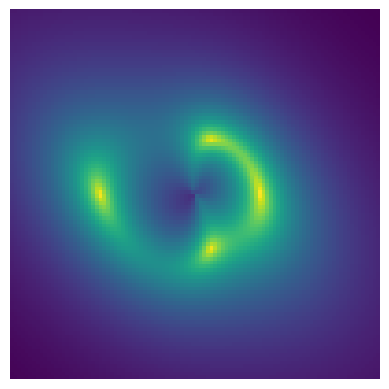

In [6]:
plt.imshow(minisim(quad_level=3).detach().cpu().numpy(), origin="lower")
plt.axis("off")
plt.show()

### The Simulator Graph

Here we take a quick look at the simulator graph for the image we have produced. You will learn much more about what this means in the `Simulators` tutorial notebook, but let's cover the basics here. First, note that this is a Directed Acyclic Graph (DAG), this is how all simulator parameters are represented in Caustics. At the top of the graph is the `Lens_Source` object, you can see in brackets it has a name `sim` which is used as the identifier for it's node in the graph. At the next level is the `z_s` parameter for the redshift of the source (recall, we passed `z_s` when constructing the simulator). Next are the `SIE` and `Sersic` objects which themselves each hold parameters. You will notice that all the parameters are in grey boxes right now, this is because we have set a value for every parameter, they will be white if the parameter is left free (i.e. for sampling).

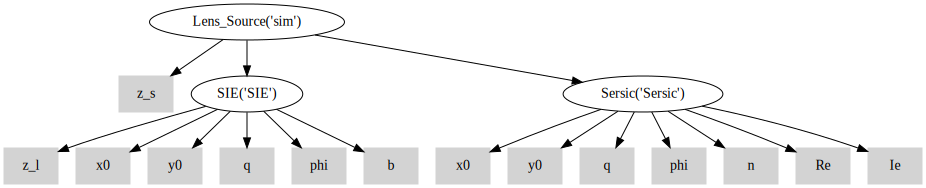

In [7]:
minisim.get_graph(True, True)

### Sampling with a Simulator

Now let's see how we can turn our simulator from a argument-less function, into a useful forward model with some parameters. First, we pick some parameters and set them to `None` (normally you would just not provide a value when you make the object). When we plot the graph you will see that now those parameters are in white boxes and so are now expected as inputs to a simulator.

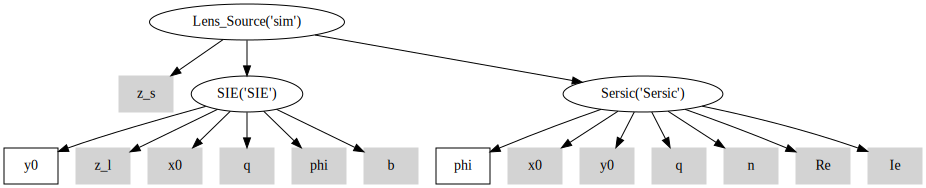

In [8]:
import torch
minisim.SIE.y0 = None
minisim.Sersic.phi = None
minisim.get_graph(True, True)

Here we can plot the configuration again, but now let's pick new values for our free parameters and pass them to the simulator. The resulting image will of course be different. Now that you have a function of some parameters, it's possible to use the power of PyTorch to massively speed up calculations using tools like `autodiff` for gradients, `vmap` for batching, and so on.

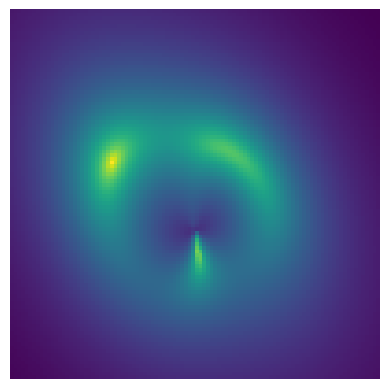

In [9]:
inputs = torch.tensor([-0.5, 2.])

plt.imshow(minisim(inputs, quad_level=3).detach().cpu().numpy(), origin="lower")
plt.axis("off")
plt.show()

## Where to go next?

The caustic tutorials are generally short and to the point, that way you can identify what you want and jump right to some useful code that demo's the particular problem you face. Below is a list of caustic tutorials and a quick description of what you will learn in each one::

- `LensZoo`: here you can see all the built-in lens mass distributions in `caustic` and how they distort the same background Seric source.
- `Playground`: here we demo the main visualizations of a lensing system (deflection angles, convergence, potential, time delay, magnification) in an interactive display so you can change the parameters by hand and see how the visuals change!
- `VisualizeCaustics`: here you can see how to find and display caustics, a must when using `caustic`!
- `Simulators`: here we describe the powerful simulator framework and how it can be used to quickly swap models, parameters, and other features and turn a complex forward model into a simple function.
- `InvertLensEquation`: here we demo forward ray tracing in `caustic` the process of mapping from the source plane to the image plane.